In [152]:
import ROOT
import os, sys, pickle

import matplotlib.pyplot as plt
import numpy as np
import collections
%matplotlib inline 

import jp_mpl as jplot

import pickle
import ratdb_reader
reload(ratdb_reader)
from scipy import interpolate
from copy import deepcopy

In [2]:
infile_name = '/home/jpyanez/snoplus/software/rat/data/PMTTRANSIT.ratdb'
dbdata = ratdb_reader.dbreader(infile_name)

reader: Creating a dict in line 4
reader: Closing a dict in line 17
reader: Creating a dict in line 19
reader: Closing a dict in line 34


In [3]:
sno_dir = '/home/jpyanez/snoplus/data/sno_laserball_data'
all_files = os.listdir(sno_dir)

In [4]:
for one_file in all_files:
    tfile = ROOT.TFile(os.path.join(sno_dir, one_file))
    print one_file, np.array(tfile.Get('lambda'))[1]
    tfile.Close()

sno_025012_p5.rch 337.0
sno_022551_p2.rch 620.0
sno_056128_p1.rch 421.0
sno_035051_p2.rch 500.0
sno_051231_p3.rch 386.0
sno_035061_p2.rch 500.0
sno_025143_p2.rch 365.0
sno_059816_p2.rch 337.0
sno_035102_p2.rch 365.0
sno_059812_p2.rch 620.0
sno_056812_p1.rch 386.0
sno_035106_p2.rch 421.0
sno_057162_p1.rch 620.0
sno_035216_p2.rch 386.0
sno_035193_p2.rch 500.0
sno_035120_p2.rch 337.0
sno_053371_p2.rch 500.0
sno_035091_p2.rch 365.0
sno_050812_p3.rch 500.0
sno_023451_p2.rch 500.0
sno_053401_p2.rch 500.0
sno_051259_p3.rch 337.0
sno_059841_p2.rch 421.0
sno_035171_p2.rch 500.0
sno_025212_p5.rch 620.0
sno_035197_p2.rch 620.0
sno_025601_p2.rch 500.0
sno_051209_p3.rch 365.0
sno_059718_p2.rch 386.0
sno_059910_p2.rch 365.0
sno_053142_p2.rch 337.0
sno_059561_p2.rch 337.0
sno_059613_p2.rch 500.0
sno_056142_p1.rch 500.0
sno_064512_p2.rch 337.0
sno_051298_p3.rch 500.0
sno_035210_p2.rch 620.0
sno_059541_p2.rch 337.0
sno_056124_p1.rch 365.0
sno_035177_p2.rch 386.0
sno_023514_p2.rch 500.0
sno_051277_p3.rc

In [239]:
#one_file = 'sno_035106_p2.rch'
#one_file = 'sno_056128_p1.rch'
#one_file = 'sno_051271_p3.rch'
#one_file = 'sno_062651_p2.rch' # This is 337 nm
#one_file = 'sno_051326_p3.rch' # This is 500 nm
#one_file = 'sno_051012_p3.rch' # This is 600nm
#one_file = 'sno_035201_p2.rch' # This is 500nm
one_file = 'sno_060151_p2.rch' # This is 500nm 
tfile = ROOT.TFile(os.path.join(sno_dir, one_file))
print 'File information'
spos = np.array(tfile.Get('source_pos'))
print 'Position: ', spos
lamb = np.array(tfile.Get('lambda'))
print 'Lambda ', lamb
cast = np.array(tfile.Get('cast'))
print 'Cast ', cast
version = np.array(tfile.Get('version'))
print 'Version ', version

File information
Position:  [ -1.01999998e+00  -9.99999978e-03   1.70000002e-01   9.96971512e+01]
Lambda  [   4.  500.]
Cast  [  4.00000000e+00   4.00000000e+00  -1.01999998e+00  -9.99999978e-03
   6.45699997e+01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   4.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]
Version  [ 1.]


In [240]:
caltime = tfile.Get('fRchTime')

In [241]:
# Getting the time binning
nbins = caltime.GetXaxis().GetNbins()
rootaxis = caltime.GetXaxis()
xaxis = np.zeros(nbins+1)
for ibin in range(nbins):
    xaxis[ibin] = rootaxis.GetBinLowEdge(ibin)
xaxis[nbins] = rootaxis.GetBinLowEdge(nbins)

In [242]:
npmts = caltime.GetYaxis().GetNbins()
fwhm_sno = np.zeros(npmts)

In [243]:
x = (xaxis[1:] + xaxis[:-1])/2.
x= x[::2]
bad_pmt = 0
for one_pmt in range(npmts):

    pmt_tres = np.zeros(nbins)

    for ibin in range(nbins):
        pmt_tres[ibin] = caltime.GetBinContent(ibin, one_pmt)
        orig_tres = deepcopy(pmt_tres)
        
    if pmt_tres.sum() < 20:
        continue

    # Merging to 0.5ns binsd
    sum_tres = pmt_tres[1:] + pmt_tres[:-1]
    sum_tres = sum_tres[::2]



    # Select a smaller time window
    mybool = (x>-15)*(x<20)
    sumx = x[mybool]
    sum_tres = sum_tres[mybool]

    spline = interpolate.UnivariateSpline(sumx, sum_tres-sum_tres.max()/2., k=3)
    
    try:
        r1, r2 = spline.roots()
        fwhm_sno[one_pmt] = r2-r1
        #print what
    except:
        bad_pmt+=1
        #print spline.roots(), one_pmt
        #test = np.linspace(-15, 20, 101)
        #jplot.unfilledBar(xaxis, orig_tres, color='r')
        #print xaxis, x
        #jplot.unfilledBar(sumx, sum_tres[:-1]-sum_tres.max()/2.)
        #plt.plot(xtest, spline(xtest), color = 'red')
        #plt.show()
        #raw_input()
    
print 'Bad', bad_pmt


Bad 858


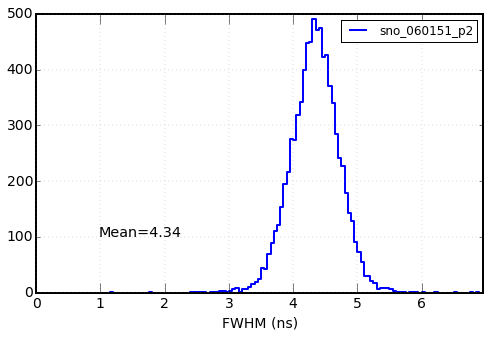

In [244]:
fig = plt.figure(figsize=(8,5))
timearray = np.arange(0, 7, 0.05)
b, _ = np.histogram(fwhm_sno[fwhm_sno>0], timearray)
jplot.unfilledBar(timearray, b, label = one_file.rstrip('.rch'))
np.median(fwhm_sno[fwhm_sno>0])
plt.xlabel('FWHM (ns)')
plt.text(1, 100, 'Mean='+"%.2f" % np.mean(fwhm_sno[fwhm_sno>0]), fontsize='x-large')
plt.legend(loc=0)
fig.savefig('/sb/project/qbs-015-aa/jpyanez/data/laserball_runs/sno_summary/' + one_file.rstrip('.rch') + '.png')